<h2>Maps Needed:</h2>

<ol class="toc" role="list">
    <li>
        Hotspot of HWM data for Helene and Milton. Probably should repeat for camera data
                <ol role="list">
            <li>
                Get HWM data and turn into a csv
            </li>
            <li>
                Make seperate csvs for Helene and Milton
            </li>
            <li>
                Figure out how to do a hotspot analysis and mapping in python
            </li>
        </ol>
    </li>
    <li>
        Map of all AWN sensors (a) and WeatherSTEM sensors (b) collecting rainfall data during the events. Also need to check Weather Underground (WU), PWSWeather, and MeteoBridge / Ecowitt.net
    </li>
    <li>
        Map of all other inputs: 
    </li>
    <li>
        Map of input derived products
    </li>
</ol>

In [3]:
import requests, json, zipfile, io, os
from datetime import date
from datetime import datetime
import dateutil.relativedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# Functions

In [4]:
def add_north_arrow(ax, x=0.08, y=0.92, size=0.08):
    """North arrow anchored to axes fraction coords."""
    ax.annotate(
        'N',
        xy=(x, y),
        xytext=(x, y - size),
        xycoords='axes fraction',
        textcoords='axes fraction',
        ha='center', va='center',
        fontsize=12, fontweight='bold',
        arrowprops=dict(arrowstyle='-|>', mutation_scale=20, lw=1.5, color='k')
    )

def add_esri_scalebar(
    ax,
    segment_km=1.0,            # length of ONE segment in km
    n_segments=6,              # number of segments (controls total length)
    location=(0.07, 0.06),     # axes-fraction (left, bottom)
    height=0.015,              # thickness as fraction of y-range
    label_every=2,             # label every N segments (2 = every other)
    text_offset_frac=0.012,    # vertical offset for labels (fraction of y-range)
):
    """
    ESRI-like alternating scale bar for EPSG:3857 (meters).
    Total length = segment_km * n_segments.
    Labels appear every `label_every` segments (plus 0 and the end).
    """
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xr = xmax - xmin
    yr = ymax - ymin

    # anchor (bottom-left of bar) in data coords
    x0 = xmin + location[0] * xr
    y0 = ymin + location[1] * yr

    # sizes in data units (meters for EPSG:3857)
    seg_m = segment_km * 1000.0
    total_m = seg_m * n_segments
    h = height * yr

    # draw alternating segments
    for i in range(n_segments):
        ax.add_patch(
            mpatches.Rectangle(
                (x0 + i * seg_m, y0),
                seg_m, h,
                facecolor=('black' if i % 2 == 0 else 'white'),
                edgecolor='black', linewidth=0.8
            )
        )

    # outline
    ax.add_patch(
        mpatches.Rectangle((x0, y0), total_m, h, fill=False,
                           edgecolor='black', linewidth=0.8)
    )

    # labels
    dy = text_offset_frac * yr
    # always label 0
    ax.text(x0, y0 - dy, '0', ha='center', va='top', fontsize=9)

    # label every `label_every` segments in the middle of the tick
    for i in range(label_every, n_segments, label_every):
        km_here = i * segment_km
        x_here = x0 + i * seg_m
        ax.text(x_here, y0 - dy, f'{int(km_here) if km_here.is_integer() else km_here:g} km',
                ha='center', va='top', fontsize=9)

    # ensure the end is labeled
    end_km = n_segments * segment_km
    ax.text(x0 + total_m, y0 - dy,
            f'{int(end_km) if end_km.is_integer() else end_km:g} km',
            ha='center', va='top', fontsize=9)


# Weather Sensors

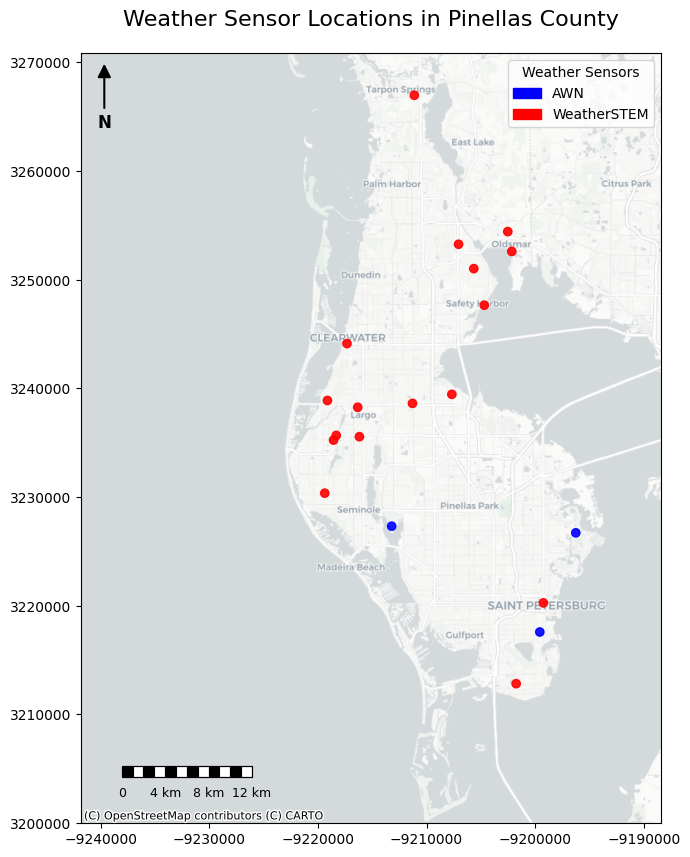

In [9]:
#query data from github
url = 'https://raw.githubusercontent.com/colarussoa/urban_flood_prediction/refs/heads/main/Data/AWN_Weatherstem_coords.txt'
response = requests.get(url)
stations = response.text.splitlines()

#get data into df
headers = stations[0].split(', ')
data_rows = []
for station in stations[1:]:
    data_rows.append(station.split(', '))
df = pd.DataFrame(data_rows, columns=headers)

#get as gdf
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])] #get geometry in porper format
gdf = GeoDataFrame(df, geometry=geometry) #Convert to gdf
gdf = gdf.set_crs('epsg:4326') #set crs to WGS84
gdf = gdf.to_crs(epsg=3857) #convert to web mercator

geometry = [Point(xy) for xy in zip(df['long'], df['lat'])] #get geometry in porper format
gdf = GeoDataFrame(df, geometry=geometry) #Convert to gdf
gdf = gdf.set_crs('epsg:4326') #set crs to WGS84
gdf = gdf.to_crs(epsg=3857) #convert to web mercator

#plot
color_mapping = {"AWN": "blue", "WeatherSTEM": "red"} #set colors based on category

fig, ax = plt.subplots(figsize=(10, 10)) #set fig size

# points
gdf.plot(ax=ax, alpha=0.9, color=gdf["array"].map(color_mapping).tolist())

#turn off sci not
ax.ticklabel_format(style='plain', axis='both')

# bounds
ax.set_xlim(-9241804.6346, -9188379.9463)
ax.set_ylim(3199947.6362, 3270847.8020)

# basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# legend
legend_handles = [mpatches.Patch(color=c, label=lbl) for lbl, c in color_mapping.items()]
ax.legend(handles=legend_handles, title="Weather Sensors", loc="upper right")

# title
ax.set_title("Weather Sensor Locations in Pinellas County", fontsize=16, pad=20)

# north arrow + scale bar
add_north_arrow(ax, x=0.04, y=0.99, size=0.08)
add_esri_scalebar(ax, segment_km=1, n_segments=12, label_every=4)

# Save the plot with 600 DPI
plt.savefig('Figure_x_Weather Sensor Locations in Pinellas County.png', dpi=600)
